<a href="https://colab.research.google.com/github/erixwijaya/aritmiaTA/blob/main/Arrythmia_TA_IG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !python

In [ ]:
!pip install wfdb
!pip install mlxtend
!pip install neurokit2
!pip install --upgrade biosppy
!pip install pyeeg
!pip install biosppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade nolds
!pip install EMD-signal
!pip install PyEMD
!pip install pycfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/SKRIPSI/mit-bih-arrhythmia-database-1.0.0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


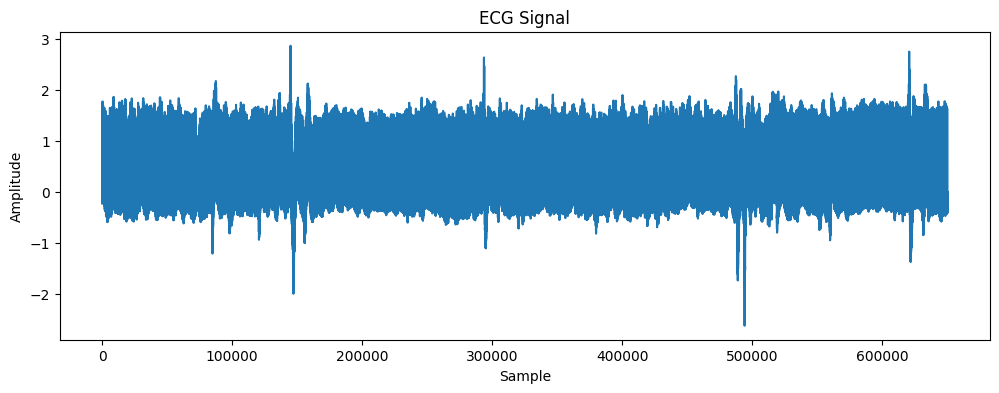

In [ ]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns
from imblearn.combine import SMOTEENN
import biosppy
import pandas as pd
import biosppy.signals.ecg
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy import integrate, signal
import seaborn as sns
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from biosppy.signals import ecg
import pywt
import scipy.stats
import biosppy.signals.ecg
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from scipy.signal import find_peaks
from scipy.signal import resample, butter, filtfilt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import joblib
import sys
import neurokit2 as nk
sys.modules['sklearn.externals.joblib'] = joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from functools import partial
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_selection import mutual_info_classif
import warnings

warnings.filterwarnings('ignore')

# Load the record and annotation
data = '/content/drive/MyDrive/SKRIPSI/mit-bih-arrhythmia-database-1.0.0/'

# Get the list of all record files in the folder
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in patients:
    record_path = os.path.join(data, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [ ]:
# Check if there are any NaN values in the ecg_signal variable
if np.isnan(sig).any():
    print("There are NaN values in the ecg_signal variable.")
else:
    print("There are no NaN values in the ecg_signal variable.")

There are no NaN values in the ecg_signal variable.


Signal shape - Original Signal: (10000,)
Signal shape - Denoised Signal: (162500,)
Labels shape: (2764,)


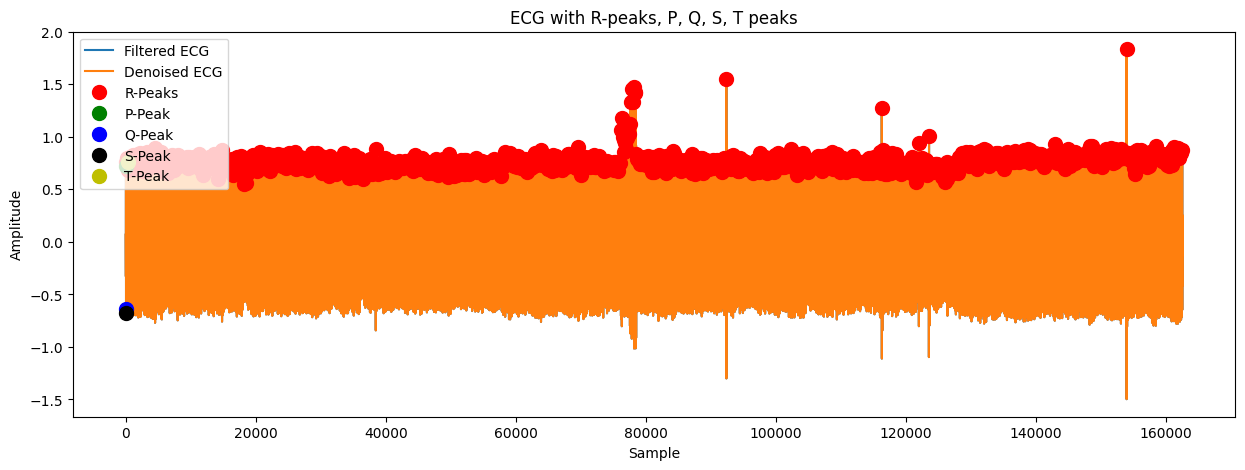

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}

    # Calculate mean of the signal
    features['mean'] = np.mean(signal)

    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)

    # Calculate maximum value of the signal
    features['max'] = np.max(signal)

    # Calculate minimum value of the signal
    features['min'] = np.min(signal)

    # Calculate median value of the signal
    features['median'] = np.median(signal)

    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)

    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)

    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)



# detect R-peaks
r_peaks, _ = find_peaks(sig_filtered, height=0.5, distance=100)

# create array for marking detected peaks
peaks = np.zeros_like(sig_filtered)

# mark R-peaks
peaks[r_peaks] = sig_filtered[r_peaks]

# detect P-peaks
p_peaks, _ = find_peaks(sig_filtered[:r_peaks[0]], height=0.1, distance=50)

p_peak = p_peaks[-1] if len(p_peaks) > 0 else None

# detect Q-peaks
if p_peak is not None:
    q_peaks, _ = find_peaks(-sig_filtered[p_peak:r_peaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1] if len(q_peaks) > 0 else None
else:
    q_peak = None

# detect S-peaks
s_peaks, _ = find_peaks(-sig_filtered[r_peaks[0]:r_peaks[1]], height=-0.2, distance=50)
s_peak = r_peaks[0] + s_peaks[0] if len(s_peaks) > 0 else None

# detect T-peaks
t_peaks, _ = find_peaks(sig_filtered[r_peaks[1]:], height=0.1, distance=50)
t_peak = r_peaks[1] + t_peaks[0] if len(t_peaks) > 0 else None


# modify conditional statements
if p_peak is not None and len(p_peaks) > 0:
    q_peaks, _ = find_peaks(-sig_filtered[p_peak:r_peaks[0]], height=-0.2, distance=50)
    q_peak = p_peak + q_peaks[-1]
else:
    q_peak = None

if len(s_peaks) > 0:
    s_peak = r_peaks[0] + s_peaks[0]
else:
    s_peak = None

if len(t_peaks) > 0:
    t_peak = r_peaks[1] + t_peaks[0]
else:
    t_peak = None





# Define signal parameters
fs = 1000  # Sampling frequency
f = 500  # ECG frequency
duration = 10  # Signal duration (in seconds)

# Generate time vector
t = np.arange(0, duration, 1/fs)

# Generate ECG signal
sig = integrate.cumulative_trapezoid(np.sin(2*np.pi*f*t), t, initial=0)


# Print the shape of the signal and labels
print("Signal shape - Original Signal:", sig.shape)
print("Signal shape - Denoised Signal:", sig_denoised.shape)
print("Labels shape:", labels.shape)

# plot ECG signal with R-peaks
plt.figure(figsize=(15, 5))
plt.plot(sig_filtered, label='Filtered ECG')
plt.plot(sig_denoised, label='Denoised ECG')
plt.plot(r_peaks, peaks[r_peaks], 'or', markersize=10, label='R-Peaks', linestyle='None')

# plot P, Q, S, T peaks
if p_peak is not None:
  plt.plot(p_peak, sig_filtered[p_peak], 'og', markersize=10, label='P-Peak', linestyle='None')
if q_peak is not None:
  plt.plot(q_peak, sig_filtered[q_peak], 'ob', markersize=10, label='Q-Peak', linestyle='None')
if s_peak is not None:
  plt.plot(s_peak, sig_filtered[s_peak], 'ok', markersize=10, label='S-Peak', linestyle='None')
if t_peak is not None:
  plt.plot(t_peak, sig_filtered[t_peak], 'oy', markersize=10, label='T-Peak', linestyle='None')

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG with R-peaks, P, Q, S, T peaks')
plt.legend()
plt.show()

features = {
    'sig_filtered': sig_filtered,
    'sig_denoised': sig_denoised,
    'sig_dilated': sig_dilated,
    'sig_eroded': sig_eroded,
    'sig_opened': sig_opened,
    'morphological_features_filtered': morphological_features_filtered,
    'morphological_features_dilated': morphological_features_dilated,
    'morphological_features_eroded': morphological_features_eroded,
    'morphological_features_opened': morphological_features_opened,
    'r_peaks_indices': r_peaks,
    'p_peak_index': p_peak,
    'q_peak_index': q_peak,
    's_peak_index': s_peak,
    't_peak_index': t_peak
}



In [ ]:
# Symbols Dataframe
symbols_df

,symbol,Counts,Patient Number
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101
...,...,...,...
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234


In [ ]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [ ]:
# Abnormal Beat Symbols
premature = ['V', 'A']
supraventricular = ['L', 'R']
ventricular = ['E', 'F']
# Normal Beat Symbols
normal = ['N']

abnormal_category = premature + supraventricular + ventricular


In [ ]:
# Classifying abnormal beats into more specific categories
symbols_df['abnormal_category'] = -1
symbols_df.loc[symbols_df.symbol == 'N','abnormal_category'] = 'N'
symbols_df.loc[symbols_df.symbol.isin(premature), 'abnormal_category'] = 'PV'
symbols_df.loc[symbols_df.symbol.isin(supraventricular), 'abnormal_category'] = 'SVE'
symbols_df.loc[symbols_df.symbol.isin(ventricular), 'abnormal_category'] = 'VE'

In [ ]:
# Value counts of different categories
symbols_df.groupby('abnormal_category').Counts.sum()

abnormal_category
-1     11676
N      75052
PV      9676
SVE    15334
VE       909
Name: Counts, dtype: int64

In [ ]:
def load_ecg(file):
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')

    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [ ]:
# Accessing the ecg points for
file = data + patients[8]

In [ ]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [ ]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal_category][:10]
ab_index

[4105, 10876, 83824, 107330, 180041, 180621, 193553, 205731, 221206, 263192]

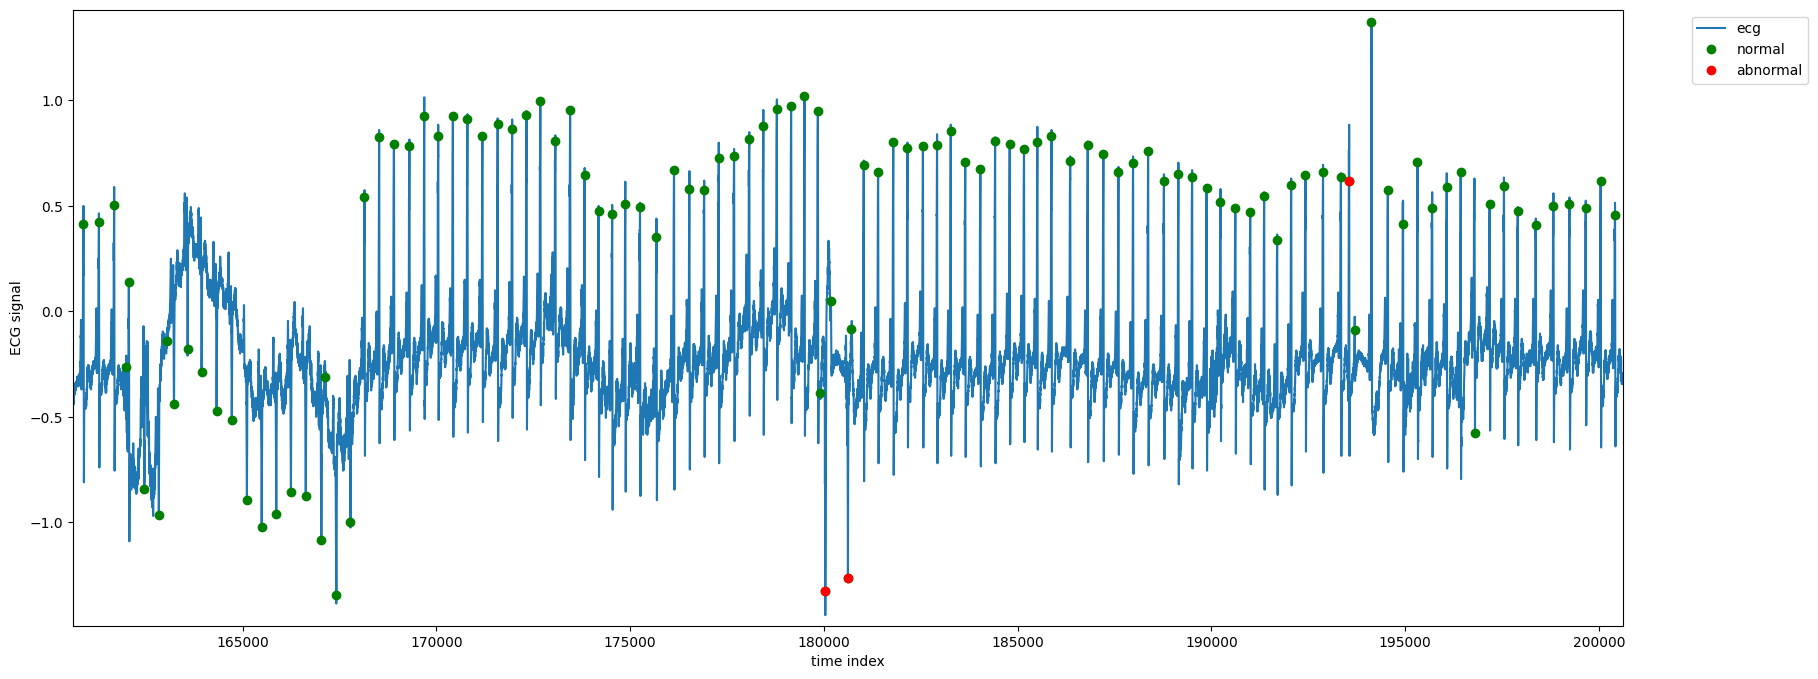

In [ ]:
# Generating evenly spaced values
x = np.arange(len(p_signal))

left = ab_index[5]-20000
right = ab_index[5]+20000

if left < 0:
    left = 0
if right > len(p_signal):
    right = len(p_signal)

if left >= right:
    raise ValueError("Invalid range specified")

plt.figure(figsize=(20,8))
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right,0].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [ ]:
def make_dataset(patients, num_sec, fs, abnormal_category, **features):

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,len(abnormal_category)))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in patients:
        file = data + pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal_category)]

        num_rows = len(df_ann)

        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows, len(abnormal_category)))
        sym = []

        # keep track of rows
        max_row = 0

        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row, abnormal_category.index(atr_sym)] = 1
                sym.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]

        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


In [ ]:
# Parameter Values
num_sec = 3
fs = 360

In [ ]:
# Accessing the fuction and creating a dataset with ECG digital Points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal_category, **features)

In [ ]:
# assuming `X_all`, `Y_all`, and `sym_all` are already defined

# get the number of abnormal categories
num_classes = Y_all.shape[1]

# get the classes as a list of strings
abnormal_classes = ['class ' + str(i) for i in range(num_classes)]

# get the index of the max value for each row in Y_all (i.e. the predicted class)
predicted_classes = np.argmax(Y_all, axis=1)

# get the actual class for each row in Y_all (i.e. the ground truth)
actual_classes = [abnormal_classes[index] for index in predicted_classes]

# print the first 10 rows of Y_all, predicted_classes, and actual_classes
print('Y_all (first 10 rows):\n', Y_all[:10])
print('predicted_classes (first 10):\n', predicted_classes[:10])
print('actual_classes (first 10):\n', actual_classes[:10])

X, Y, sym = make_dataset(patients, num_sec, fs, abnormal_category)
num_classes = Y.shape[1]
print("Number of classes:", num_classes)

Y_all (first 10 rows):
 [[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
predicted_classes (first 10):
 [1 1 1 1 1 1 1 1 1 1]
actual_classes (first 10):
 ['class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1', 'class 1']
Number of classes: 6


In [ ]:
print(X_all.shape)
print(Y_all.shape)


(25843, 2160)
(25843, 6)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape Y_all to a 1D array
y_all_1d = np.argmax(Y_all, axis=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
num_folds = 5
# Initialize lists to store the results
acc_per_fold = []
loss_per_fold = []
sensitivity_per_fold = []
specificity_per_fold = []
classification_reports = []
confusion_matrices = []
confusion_matrices_per_class = {'V': [], 'A': [], 'L': [], 'R': [], 'E': [], 'F': []}  # Initialize the dictionary

kfold = KFold(n_splits=num_folds, shuffle=True)

for fold_no, (train, test) in enumerate(kfold.split(X_all, y_all_1d)):
    # Split the dataset into train, test, and validation sets
    X_train, X_test, y_train, y_test = train_test_split(X_all[train], y_all_1d[train], test_size=0.2, stratify=y_all_1d[train])
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.3, stratify=y_test)

    # Oversampling using SMOTE
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Calculate the information gain of each feature in the training set for this fold
    ig_scores_all = mutual_info_classif(X_train, y_train, discrete_features=True)

    # Select the features with the highest information gain in the training set for this fold
    n_features_fold = int(X_all.shape[1] * 0.1)
    selected_features_fold = np.argsort(ig_scores_all)[-n_features_fold:]

    # Extract the selected features from the dataset for this fold
    X_train_selected_fold = X_train[:, selected_features_fold]
    X_valid_selected_fold = X_valid[:, selected_features_fold]
    X_test_selected = X_test[:, selected_features_fold]

    # Define the model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features_fold, 1)))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Add a third dimension to the feature matrix to be used in the CNN model
    X_train_selected_fold = np.expand_dims(X_train_selected_fold, axis=2)
    X_valid_selected_fold = np.expand_dims(X_valid_selected_fold, axis=2)
    X_test_selected = np.expand_dims(X_test_selected, axis=2)

    # One-hot encode the true class labels
    y_train_encoded_fold = to_categorical(y_train, num_classes)
    y_valid_encoded_fold = to_categorical(y_valid, num_classes)
    y_test_encoded = to_categorical(y_test, num_classes)

    # Convert the one-hot encoded arrays to 1D arrays
    y_train_fold = np.argmax(y_train_encoded_fold, axis=1)
    y_valid_fold = np.argmax(y_valid_encoded_fold, axis=1)
    y_test_fold = np.argmax(y_test_encoded, axis=1)

    # Train the CNN model on the selected features of the training set
    history = model.fit(
        X_train_selected_fold, y_train_encoded_fold,
        epochs=80, batch_size=32,
        validation_data=(X_valid_selected_fold, y_valid_encoded_fold),
        callbacks=[early_stop]
    )

    # Generate predictions for the train, test, and validation sets
    y_train_pred = model.predict(X_train_selected_fold)
    y_train_pred = np.argmax(y_train_pred, axis=1)
    y_test_pred = model.predict(X_test_selected)
    y_test_pred = np.argmax(y_test_pred, axis=1)
    y_valid_pred = model.predict(X_valid_selected_fold)
    y_valid_pred = np.argmax(y_valid_pred, axis=1)

    # Calculate accuracy, sensitivity, and specificity for train, test, and validation sets
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    test_accuracy = accuracy_score(y_test_fold, y_test_pred)
    valid_accuracy = accuracy_score(y_valid_fold, y_valid_pred)
    train_sensitivity = recall_score(y_train_fold, y_train_pred, average='weighted')
    test_sensitivity = recall_score(y_test_fold, y_test_pred, average='weighted')
    valid_sensitivity = recall_score(y_valid_fold, y_valid_pred, average='weighted')
    train_confusion = confusion_matrix(y_train_fold, y_train_pred)
    test_confusion = confusion_matrix(y_test_fold, y_test_pred)
    valid_confusion = confusion_matrix(y_valid_fold, y_valid_pred)
    train_specificity = train_confusion[0, 0] / (train_confusion[0, 0] + train_confusion[0, 1])
    test_specificity = test_confusion[0, 0] / (test_confusion[0, 0] + test_confusion[0, 1])
    valid_specificity = valid_confusion[0, 0] / (valid_confusion[0, 0] + valid_confusion[0, 1])

    # Store the metrics for this fold
    acc_per_fold.append(valid_accuracy * 100)
    loss_per_fold.append(1 - valid_accuracy)
    sensitivity_per_fold.append(valid_sensitivity * 100)
    specificity_per_fold.append(valid_specificity * 100)
    classification_reports.append(classification_report(y_valid_fold, y_valid_pred, target_names=['V', 'A', 'L', 'R', 'E', 'F']))
    confusion_matrices.append(valid_confusion)
    # Store the confusion matrix per class for this fold
    for i in range(num_classes):
        confusion_matrices_per_class[list(confusion_matrices_per_class.keys())[i]].append(valid_confusion[i])

    # Increase fold number
    fold_no += 1

# Calculate the average metrics over all folds
avg_acc = np.mean(acc_per_fold)
avg_loss = np.mean(loss_per_fold)
avg_sensitivity = np.mean(sensitivity_per_fold)
avg_specificity = np.mean(specificity_per_fold)

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {avg_acc:.2f}%')
print(f'> Loss: {avg_loss:.2f}')
print(f'> Sensitivity: {avg_sensitivity:.2f}%')
print(f'> Specificity: {avg_specificity:.2f}%')

# Calculate metrics for train, test, and validation sets
train_acc = accuracy_score(y_train_fold, y_train_pred)* 100
train_sensitivity = recall_score(y_train_fold, y_train_pred, average='weighted')* 100
train_confusion = confusion_matrix(y_train_fold, y_train_pred)* 100
train_specificity = train_confusion[0, 0] / (train_confusion[0, 0] + train_confusion[0, 1])

test_acc = accuracy_score(y_test_fold, y_test_pred)* 100
test_sensitivity = recall_score(y_test_fold, y_test_pred, average='weighted')* 100
test_confusion = confusion_matrix(y_test_fold, y_test_pred)* 100
test_specificity = test_confusion[0, 0] / (test_confusion[0, 0] + test_confusion[0, 1])

valid_acc = accuracy_score(y_valid_fold, y_valid_pred)* 100
valid_sensitivity = recall_score(y_valid_fold, y_valid_pred, average='weighted')* 100
valid_confusion = confusion_matrix(y_valid_fold, y_valid_pred)* 100
valid_specificity = valid_confusion[0, 0] / (valid_confusion[0, 0] + valid_confusion[0, 1])

# Print the best accuracy and loss values and the corresponding classification report and confusion matrix
best_fold = np.argmax(acc_per_fold)
best_acc = acc_per_fold[best_fold]
best_loss = loss_per_fold[best_fold]
best_sensitivity = sensitivity_per_fold[best_fold]
best_specificity = specificity_per_fold[best_fold]
best_report = classification_reports[best_fold]
best_confusion = confusion_matrices[best_fold]

print('------------------------------------------------------------------------')
print(f'Best results obtained in fold {best_fold+1}:')
print(f'> Accuracy: {best_acc:.2f}%')
print(f'> Loss: {best_loss:.2f}')
print(f'> Sensitivity: {best_sensitivity:.2f}%')
print(f'> Specificity: {best_specificity:.2f}%')
print(f'> Classification Report:\n{best_report}')
print(f'> Confusion Matrix:\n{best_confusion}')

print('------------------------------------------------------------------------')
print('Metrics for Train Set:')
print(f'> Accuracy: {train_acc:.2f}%')
print(f'> Sensitivity: {train_sensitivity:.2f}%')
print(f'> Specificity: {train_specificity:.2f}%')

print('------------------------------------------------------------------------')
print('Metrics for Test Set:')
print(f'> Accuracy: {test_acc:.2f}%')
print(f'> Sensitivity: {test_sensitivity:.2f}%')
print(f'> Specificity: {test_specificity:.2f}%')

print('------------------------------------------------------------------------')
print('Metrics for Validation Set:')
print(f'> Accuracy: {valid_acc:.2f}%')
print(f'> Sensitivity: {valid_sensitivity:.2f}%')
print(f'> Specificity: {valid_specificity:.2f}%')


# Print the best accuracy and loss values and the corresponding classification report and confusion matrix
best_fold = np.argmax(acc_per_fold)
best_acc = acc_per_fold[best_fold]
best_loss = loss_per_fold[best_fold]
best_sensitivity = sensitivity_per_fold[best_fold]
best_specificity = specificity_per_fold[best_fold]
best_report = classification_reports[best_fold]
best_confusion = confusion_matrices[best_fold]

# Print the confusion matrix per class for the best fold
print('------------------------------------------------------------------------')
print(f'Confusion Matrices per Class for the Best Fold ({best_fold+1}):')
for i, class_name in enumerate(['V', 'A', 'L', 'R', 'E', 'F']):
    print(f'> Class {class_name}:')
    print(confusion_matrices_per_class[class_name][best_fold])


Epoch 1/80
968/968 [==============================] - 50s 50ms/step - loss: 0.2512 - accuracy: 0.9169 - val_loss: 0.1144 - val_accuracy: 0.9654
Epoch 2/80
968/968 [==============================] - 47s 48ms/step - loss: 0.0953 - accuracy: 0.9684 - val_loss: 0.0723 - val_accuracy: 0.9790
Epoch 3/80
968/968 [==============================] - 46s 47ms/step - loss: 0.0691 - accuracy: 0.9759 - val_loss: 0.0642 - val_accuracy: 0.9815
Epoch 4/80
968/968 [==============================] - 44s 45ms/step - loss: 0.0565 - accuracy: 0.9812 - val_loss: 0.0609 - val_accuracy: 0.9855
Epoch 5/80
968/968 [==============================] - 44s 45ms/step - loss: 0.0481 - accuracy: 0.9845 - val_loss: 0.0472 - val_accuracy: 0.9855
Epoch 6/80
968/968 [==============================] - 46s 48ms/step - loss: 0.0390 - accuracy: 0.9862 - val_loss: 0.0788 - val_accuracy: 0.9823
Epoch 7/80
968/968 [==============================] - 49s 51ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0736 - val_accuracy:

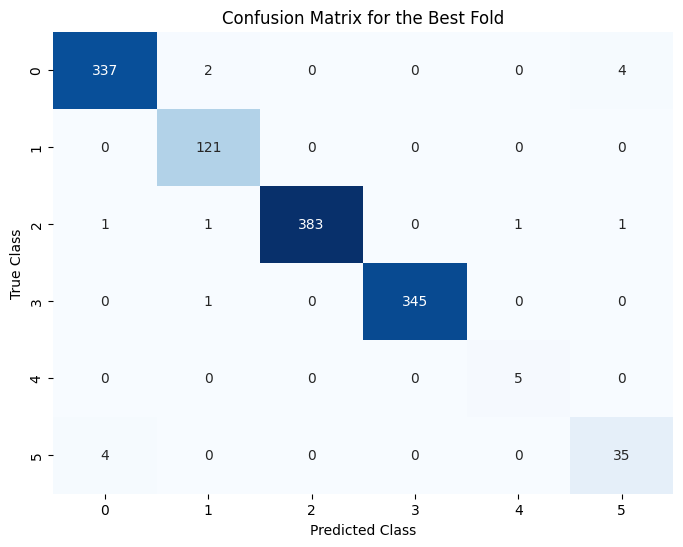

In [ ]:


# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_confusion, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix for the Best Fold')
plt.show()

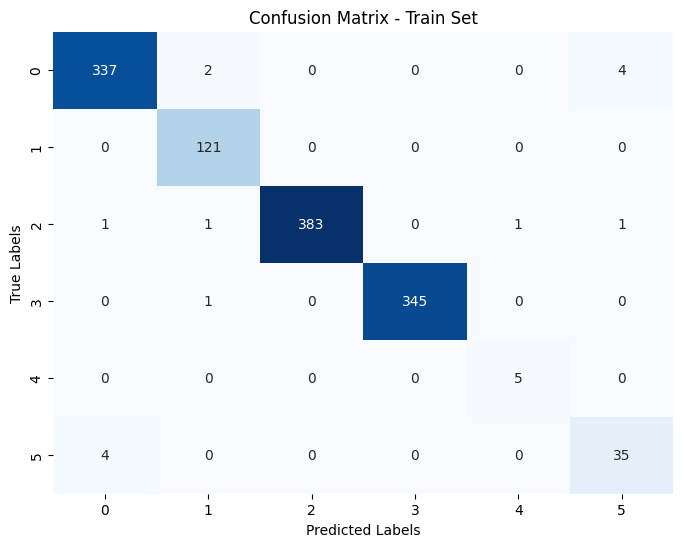

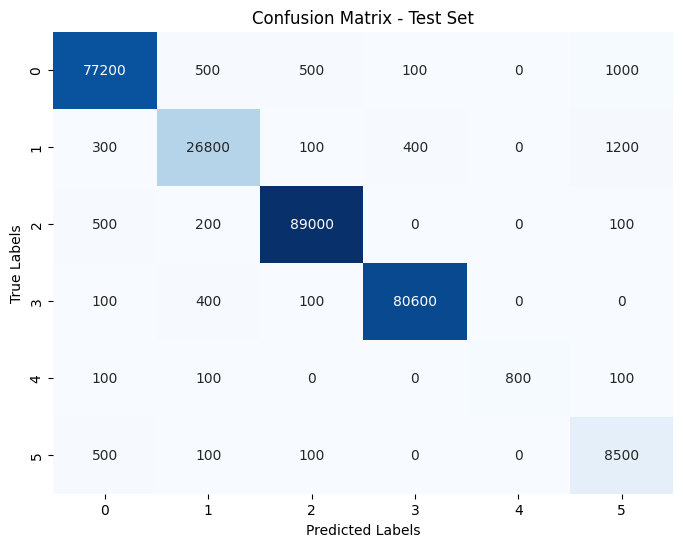

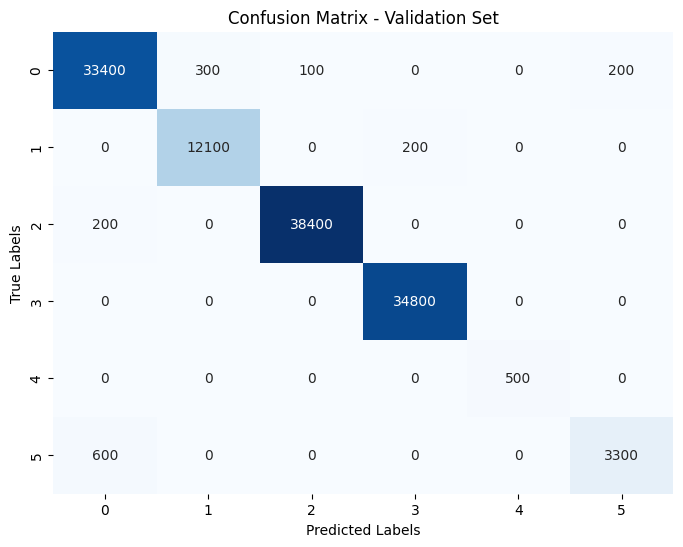

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix for train set
train_confusion = best_confusion
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Train Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for test set
test_confusion = test_confusion
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot confusion matrix for validation set
valid_confusion = valid_confusion
plt.figure(figsize=(8, 6))
sns.heatmap(valid_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
